In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd

cell_df="/home/maria/LuckyMouse2/neuron_property_decoding/data/cell_metrics_joined.csv"
neuron_embeddings="/home/maria/LuckyMouse2/neuron_property_decoding/data/neuron_embeddings.npy"
cell_df=pd.read_csv(cell_df)
neuron_embeddings=np.load(neuron_embeddings)
merged_df=cell_df
X=neuron_embeddings
# Load embeddings (e.g. from your model output)
#X = np.load("/path/to/your_neuron_embeddings.npy")  # shape (N, 64)
merged_df = merged_df.sort_values("data_row_index").reset_index(drop=True)

# Select targets
targets = [
    'osi_dg', 'dsi_dg', 'g_osi_dg', 'g_dsi_dg',
    'reliability_dg', 'reliability_nm1_a',
    'run_mod_dg', 'tfdi_dg', 'pref_tf_dg',
    'peak_dff_dg'
]
Y_df = merged_df[targets]

Y_df_filled = Y_df.fillna(0.0)
Y = Y_df_filled.to_numpy(dtype=np.float32)
class NeuronPropertyDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
        self.mask = ~torch.isnan(self.Y)  # 1 where target exists

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx], self.mask[idx]
    
import torch.nn as nn

class MultiTaskRegressor(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Split data
train_idx, test_idx = train_test_split(
    np.arange(X.shape[0]), test_size=0.2, random_state=42
)

train_dataset = NeuronPropertyDataset(X[train_idx], Y[train_idx])
test_dataset = NeuronPropertyDataset(X[test_idx], Y[test_idx])
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiTaskRegressor(input_dim=X.shape[1], output_dim=Y.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def masked_mse_loss(pred, target, mask):
    diff = pred - target
    loss = (diff**2 * mask).sum() / mask.sum()
    return loss

# Training loop
n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for x_batch, y_batch, mask_batch in train_loader:
        x_batch, y_batch, mask_batch = x_batch.to(device), y_batch.to(device), mask_batch.to(device)
        preds = model(x_batch)
        loss = masked_mse_loss(preds, y_batch, mask_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{n_epochs} | Loss: {total_loss:.4f}")

model.eval()
with torch.no_grad():
    X_test = torch.tensor(X[test_idx], dtype=torch.float32).to(device)
    Y_test = torch.tensor(Y[test_idx], dtype=torch.float32).to(device)
    mask_test = ~torch.isnan(Y_test)

    preds = model(X_test)
    preds = preds.cpu().numpy()
    Y_test = Y_test.cpu().numpy()
    mask_test = mask_test.cpu().numpy()

# R² for each task
print("\n📈 Variance explained per property:")
for i, name in enumerate(targets):
    mask = mask_test[:, i]
    if mask.sum() == 0:
        print(f"{name}: No data")
        continue
    r2 = r2_score(Y_test[mask, i], preds[mask, i])
    print(f"{name}: R² = {r2:.4f}")



Epoch 1/100 | Loss: 60157.2138
Epoch 2/100 | Loss: 59881.9865
Epoch 3/100 | Loss: 59798.8733
Epoch 4/100 | Loss: 59694.1574
Epoch 5/100 | Loss: 59590.5330
Epoch 6/100 | Loss: 59453.4997
Epoch 7/100 | Loss: 59364.0451
Epoch 8/100 | Loss: 59393.5859
Epoch 9/100 | Loss: 59175.0939
Epoch 10/100 | Loss: 59024.8571
Epoch 11/100 | Loss: 58934.6073
Epoch 12/100 | Loss: 58722.4626
Epoch 13/100 | Loss: 58490.3666
Epoch 14/100 | Loss: 58175.9805
Epoch 15/100 | Loss: 57643.2842
Epoch 16/100 | Loss: 57100.8867
Epoch 17/100 | Loss: 56431.3131
Epoch 18/100 | Loss: 55656.4530
Epoch 19/100 | Loss: 54634.9316
Epoch 20/100 | Loss: 53655.8958
Epoch 21/100 | Loss: 52521.8843
Epoch 22/100 | Loss: 51113.2843
Epoch 23/100 | Loss: 49612.7865
Epoch 24/100 | Loss: 55705.6016
Epoch 25/100 | Loss: 46553.8355
Epoch 26/100 | Loss: 44019.6302
Epoch 27/100 | Loss: 42580.0331
Epoch 28/100 | Loss: 40219.3167
Epoch 29/100 | Loss: 37481.2137
Epoch 30/100 | Loss: 36145.3332
Epoch 31/100 | Loss: 34203.4747
Epoch 32/100 | Lo

In [8]:
print("\n📈 Variance explained per property:")
for i, name in enumerate(targets):
    mask = mask_test[:, i]
    if mask.sum() == 0:
        print(f"{name}: No data")
        continue
    r2 = r2_score(Y_test[mask, i], preds[mask, i])
    print(f"{name}: R² = {r2:.4f}")


📈 Variance explained per property:
osi_dg: R² = -0.5606
dsi_dg: R² = -0.0886
g_osi_dg: R² = -0.3425
g_dsi_dg: R² = -0.2840
reliability_dg: R² = -3.7606
reliability_nm1_a: R² = -1.6857
run_mod_dg: R² = -0.1101
tfdi_dg: R² = -0.4426
pref_tf_dg: R² = -0.0158
peak_dff_dg: R² = -0.8350


Y shape: (39209, 10)


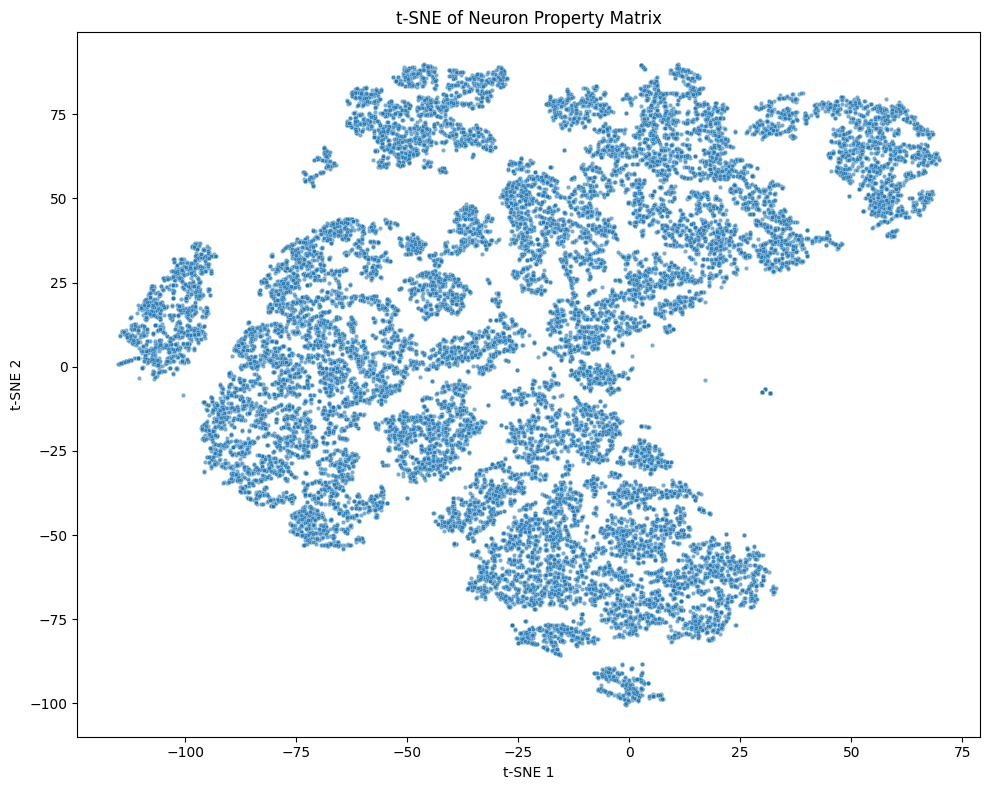

In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Y should already be filled and float32
# Shape: (n_neurons, n_properties)
print("Y shape:", Y.shape)

# Optional: standardize the features before t-SNE
from sklearn.preprocessing import StandardScaler
Y_std = StandardScaler().fit_transform(Y)

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
Y_tsne = tsne.fit_transform(Y_std)

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=Y_tsne[:, 0], y=Y_tsne[:, 1], s=10, alpha=0.6)
plt.title("t-SNE of Neuron Property Matrix")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()


/home/maria/global_venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/maria/global_venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


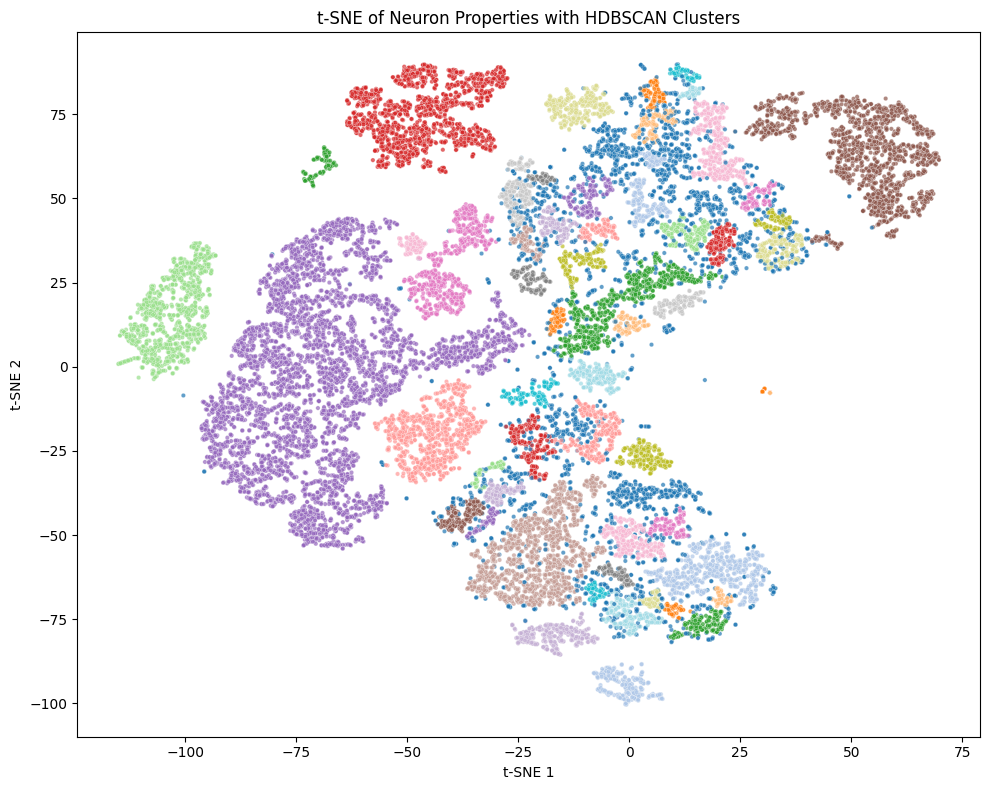

In [15]:
import hdbscan

# Fit HDBSCAN on the 2D t-SNE space
clusterer = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=10)
cluster_labels = clusterer.fit_predict(Y_tsne)

# Add labels to DataFrame
merged_df['cluster'] = cluster_labels

# Visualize
plt.figure(figsize=(10, 8))
sns.scatterplot(x=Y_tsne[:, 0], y=Y_tsne[:, 1], hue=cluster_labels,
                palette='tab20', s=10, alpha=0.7, legend=None)
plt.title("t-SNE of Neuron Properties with HDBSCAN Clusters")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()


In [ ]:
cluster_labels.shape


array([False, False, False, ..., False, False, False], shape=(39209,))

✅ Using 36417 neurons across 63 clusters

✅ Accuracy: 0.0030

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        65
           1       0.02      0.11      0.04        18
           2       0.00      0.00      0.00      2400
           3       0.00      0.00      0.00        30
           4       0.00      0.00      0.00       245
           5       0.00      0.00      0.00       362
           6       0.00      0.00      0.00       218
           7       0.00      0.00      0.00      1276
           8       0.00      0.00      0.00        69
           9       0.00      0.00      0.00       383
          10       0.00      0.08      0.00        12
          11       0.00      0.00      0.00       159
          12       0.04      0.04      0.04        25
          13       0.01      0.04      0.02        26
          14       0.00      0.00      0.00        31
          15       0.00      0.00      0.00     

/home/maria/global_venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/maria/global_venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/maria/global_venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0]

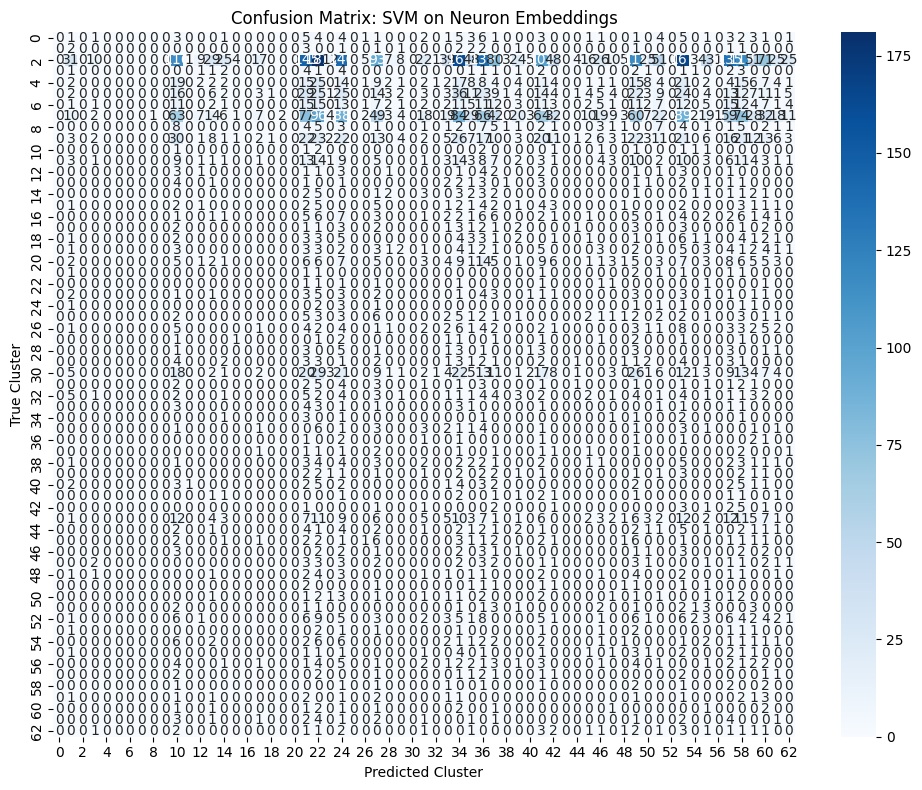

In [20]:
import numpy as np
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# -- Load data --
# X: your neuron embeddings (shape [N, D])
# cluster_labels: cluster assignments for each neuron
# If cluster_labels came from merged_df['cluster'], convert to numpy:
y = merged_df['cluster'].to_numpy()

# -- Filter out noise points if using HDBSCAN (label == -1) --
mask = y != -1
X_clean = X[mask]
y_clean = y[mask]

print(f"✅ Using {X_clean.shape[0]} neurons across {len(np.unique(y_clean))} clusters")

# -- Stratified split --
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, stratify=y_clean, random_state=42
)

# -- Train linear SVM with balanced class weights --
clf = LinearSVC(random_state=42, max_iter=10000, class_weight='balanced')
clf.fit(X_train, y_train)

# -- Predict & evaluate --
y_pred = clf.predict(X_test)

print(f"\n✅ Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

# -- Confusion matrix --
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Cluster")
plt.ylabel("True Cluster")
plt.title("Confusion Matrix: SVM on Neuron Embeddings")
plt.tight_layout()
plt.show()


In [21]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# --- Data (assume X and y are loaded) ---
y = merged_df['cluster'].to_numpy()
mask = y != -1
X_clean = X[mask]
y_clean = y[mask]

# Encode y into contiguous labels (0, 1, 2, ...) for PyTorch
unique_labels, y_encoded = np.unique(y_clean, return_inverse=True)
num_classes = len(unique_labels)

print(f"✅ Using {X_clean.shape[0]} neurons across {num_classes} clusters")

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# --- Class weights for imbalance ---
class_counts = Counter(y_train)
total = sum(class_counts.values())
weights = [total / class_counts[i] for i in range(num_classes)]
class_weights = torch.tensor(weights, dtype=torch.float32)

# --- Dataset ---
class NeuronClusterDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = NeuronClusterDataset(X_train, y_train)
test_dataset = NeuronClusterDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512)

# --- MLP Model ---
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPClassifier(input_dim=X.shape[1], hidden_dim=128, num_classes=num_classes).to(device)

# --- Loss and optimizer ---
loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# --- Training loop ---
n_epochs = 50
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        logits = model(x_batch)
        loss = loss_fn(logits, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{n_epochs} | Loss: {total_loss:.4f}")


✅ Using 36417 neurons across 63 clusters
Epoch 1/50 | Loss: 473.4771
Epoch 2/50 | Loss: 469.9977
Epoch 3/50 | Loss: 466.2657
Epoch 4/50 | Loss: 460.8677
Epoch 5/50 | Loss: 453.5253
Epoch 6/50 | Loss: 445.4961
Epoch 7/50 | Loss: 438.0996
Epoch 8/50 | Loss: 432.2776
Epoch 9/50 | Loss: 424.9423
Epoch 10/50 | Loss: 416.9952
Epoch 11/50 | Loss: 410.5567
Epoch 12/50 | Loss: 404.0759
Epoch 13/50 | Loss: 398.7013
Epoch 14/50 | Loss: 392.7506
Epoch 15/50 | Loss: 388.2899
Epoch 16/50 | Loss: 382.9407
Epoch 17/50 | Loss: 376.8604
Epoch 18/50 | Loss: 372.2753
Epoch 19/50 | Loss: 370.5763
Epoch 20/50 | Loss: 364.4323
Epoch 21/50 | Loss: 359.6709
Epoch 22/50 | Loss: 355.9575
Epoch 23/50 | Loss: 351.9750
Epoch 24/50 | Loss: 347.8830
Epoch 25/50 | Loss: 345.7452
Epoch 26/50 | Loss: 342.3448
Epoch 27/50 | Loss: 338.0759
Epoch 28/50 | Loss: 335.3866
Epoch 29/50 | Loss: 332.1005
Epoch 30/50 | Loss: 332.2687
Epoch 31/50 | Loss: 327.8890
Epoch 32/50 | Loss: 325.5688
Epoch 33/50 | Loss: 319.0245
Epoch 34/50


✅ Accuracy: 0.0041

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.02      0.03      0.02        65
           1       0.00      0.00      0.00        18
           2       0.00      0.00      0.00      2400
           3       0.00      0.00      0.00        30
           4       0.00      0.00      0.00       245
           5       0.00      0.00      0.00       362
           6       0.00      0.00      0.00       218
           7       0.00      0.00      0.00      1276
           8       0.02      0.03      0.02        69
           9       0.00      0.00      0.00       383
          10       0.00      0.00      0.00        12
          11       0.09      0.01      0.01       159
          12       0.00      0.00      0.00        25
          13       0.00      0.00      0.00        26
          14       0.00      0.03      0.01        31
          15       0.00      0.00      0.00        43
          16       0.00      0.00  

/home/maria/global_venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/maria/global_venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/maria/global_venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0]

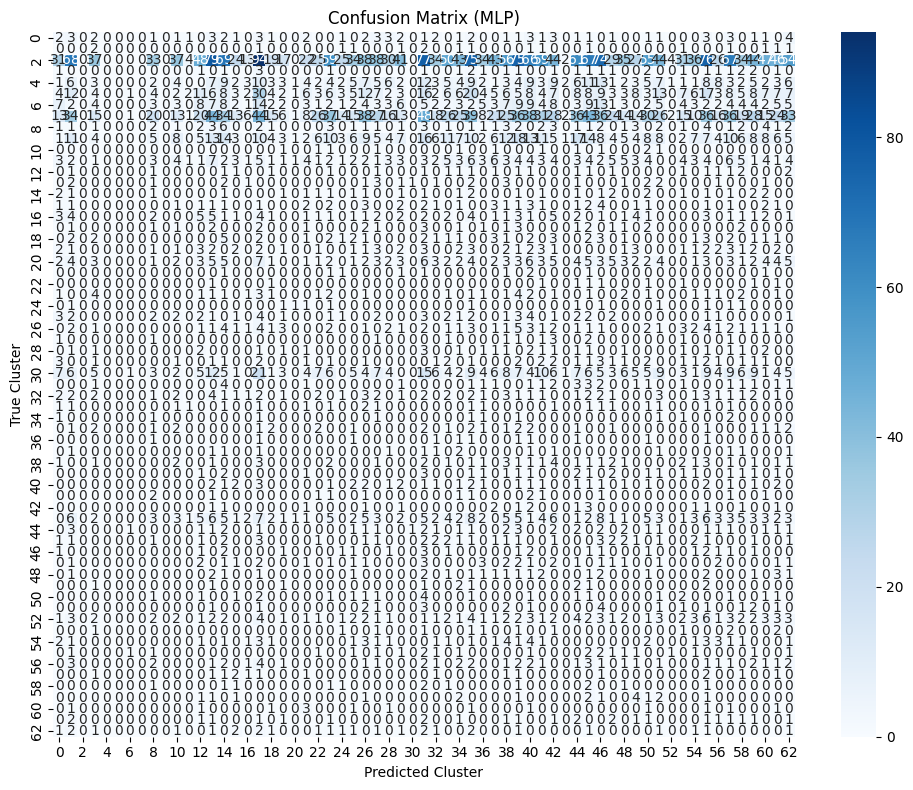

In [22]:
# --- Evaluation ---
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        logits = model(x_batch)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y_batch.numpy())

print(f"\n✅ Accuracy: {accuracy_score(all_labels, all_preds):.4f}")
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds))

# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Cluster")
plt.ylabel("True Cluster")
plt.title("Confusion Matrix (MLP)")
plt.tight_layout()
plt.show()


In [23]:
import umap
import numpy as np
import pandas as pd
import plotly.express as px

# --- Inputs ---
X = neuron_embeddings  # shape (N, 64)
cluster_labels = merged_df['cluster'].to_numpy()

# Remove noise points if using HDBSCAN (-1)
mask = cluster_labels != -1
X_clean = X[mask]
labels_clean = cluster_labels[mask]

# --- UMAP ---
umap_model = umap.UMAP(n_components=3, random_state=42)
X_umap = umap_model.fit_transform(X_clean)

# --- Plotly 3D scatter ---
fig = px.scatter_3d(
    x=X_umap[:, 0],
    y=X_umap[:, 1],
    z=X_umap[:, 2],
    color=labels_clean.astype(str),  # convert to str for categorical coloring
    title="Neuron Embeddings Colored by Cluster",
    labels={"color": "Cluster ID"},
    opacity=0.7
)

fig.update_traces(marker=dict(size=3))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=40))
fig.show()


/home/maria/global_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/maria/global_venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
